- Author: Gyu Rie Lee wrote the main body, Linna An with some edits
#### You need to install RDKit before using this notebook
- New conda environment; version.
- Install RDKit: https://www.rdkit.org/docs/Install.html
- In the same environment, install numpy, seanborn.
- After RDkit installation, load the environment for jupyter notebook usage: https://wiki.ipd.uw.edu/it/jupyterhub

### References
- https://nbviewer.org/github/iwatobipen/chemo_info/blob/master/rdkit_notebook/rdkit_3d.ipynb
- https://github.com/dkoes/rdkit-scripts/blob/master/rdconf.py
- https://gist.github.com/tdudgeon/b061dc67f9d879905b50118408c30aac
- https://www.rdkit.org/docs/source/rdkit.Chem.rdMolAlign.html
- mol file: https://chem.libretexts.org/Courses/University_of_Arkansas_Little_Rock/ChemInformatics_(2017)%3A_Chem_4399_5399/2.2%3A_Chemical_Representations_on_Computer%3A_Part_II/2.2.2%3A_Anatomy_of_a_MOL_file
- RDKit cookbook: https://www.rdkit.org/docs/Cookbook.html

#### Other options: 
- minimize the conformers use AIMNET, Linna found no significant difference for most ligands. May be worth it for highly conjugated molecules.

In [1]:
import os
import sys
import glob
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import py3Dmol
import subprocess

## Part 1. Ligand conformer generation and clustering using RDKIT with ETKDGv2 parameters

In [2]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
from rdkit.Chem import rdDistGeom,rdBase,rdMolAlign,rdMolDescriptors
from rdkit.Chem import rdmolfiles
from rdkit.Chem import AllChem,TorsionFingerprints
from rdkit.Chem import rdMolAlign
from rdkit.ML.Cluster import Butina
from rdkit.Chem import PandasTools
from rdkit.Chem.AllChem import MMFFOptimizeMolecule,MMFFGetMoleculeProperties,MMFFGetMoleculeForceField

In [3]:
print(rdBase.rdkitVersion)

2024.09.5


In [4]:
work_dir = './' # change to your work directory
os.chdir(work_dir)
!pwd  #this will be your working directory.

/home/wh621/Desktop/Structure_Database


### Input loading to rdkit 
### ***ASSIGN INPUT MOL2 FILE AND PARAMETERS HERE***

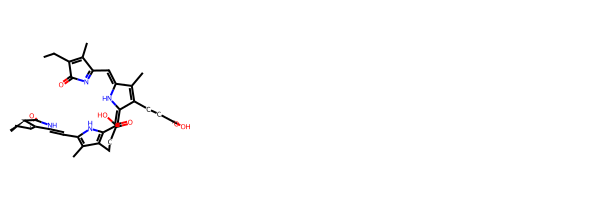

In [5]:
#ligands
# from chimera or VMD (call from /software/utilis/vmd) to edit the molecule
# assign correct hydrogen, valence, charge.
# format: 
# ligands = {name,[initial_sdf, mol2, aligned_atms(leave empty first)]}
# required_atms should be adjusted based on rifgen rif size results. too small rif
# hurt rifdock significantly

#How many conf you want to generate. Can be changed.
N_CONF = 2500

#Conformer all-atom RMSD threshold that will be used for clustering. Can be changed.
RMSD_THRESHOLD = 0.5

# format {'3_letter_ligand_name':['path_to_sdf','path_to_mol2',(assign_later)]}
ligands = {'PCB':['pcb.sdf',\
                  'new_pcb.mol2',()]}

mols = []
for lig in ligands:
    mols.extend([m for m in Chem.SDMolSupplier(ligands[lig][0])])
Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200))
# if cannot draw, check if you ligand has any chemical error, this is common for conjugated bonds
# ligand position are from 2D information, 
# may plot individually if previous 2D information doesn't show ligand clearly.

In [6]:
def prepare_rotamers(mol2_file,lig):
    mol2_file = ligands[lig][1] 
    #Example
    #Found vib from CSD (1122739) and only took the vib molecule
    #converted cif file to mol2 file with am1-bcc charge using Chimera
    #Hydrogen already included. atom type already specified with sybyl atom type in mol2 format
    input_mol2_test = mol2_file 
    header = lig 

    #load mol2 file into Mol type (rdkit). 
    #Do not remove Hs if they already exist (and you would like to keep them).
    m_mol = Chem.rdmolfiles.MolFromMol2File(input_mol2_test,removeHs=False)
    #other wise 
    #m_mol_addh = Chem.AddHs(m_mol)

    #Make a copy to keep a reference
    ref_mol = copy.deepcopy(m_mol)

    #string content. Atom names will get deleted in Mol type. But the order is the same. 
    ref_mol_block = Chem.MolToMolBlock(ref_mol)
    print (ref_mol_block)
    
    return ref_mol, m_mol, ref_mol_block

In [7]:
lig_mols = {}
for lig in ligands:
    mol2_file = ligands[lig][1]
    ref_mol, m_mol, ref_mol_block = prepare_rotamers(mol2_file,lig)
    lig_mols[lig] = [ref_mol, m_mol, ref_mol_block]

20055378
     RDKit          3D

 81 84  0  0  0  0  0  0  0  0999 V2000
   -5.1111   -0.5862    2.0420 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.2092   -0.5158    2.5160 O   0  0  0  0  0  0  0  0  0  0  0  0
    7.9421   -1.5201    0.1139 O   0  0  0  0  0  0  0  0  0  0  0  0
    3.3830   -1.1372    2.7097 O   0  0  0  0  0  0  0  0  0  0  0  0
    7.3793   -1.2863   -2.0743 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5747    2.0927    1.8089 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0650   -1.6953   -1.2224 N   0  0  0  0  0  0  0  0  0  0  0  0
    1.5900    0.9173   -0.3482 N   0  0  0  0  0  0  0  0  0  0  0  0
   -3.5495   -1.4020    0.5134 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4031    2.3361    1.0089 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.6758   -2.9586    0.4470 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.0468   -2.0191   -0.4896 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7076   -3.2084    0.2708 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1399   -2.4

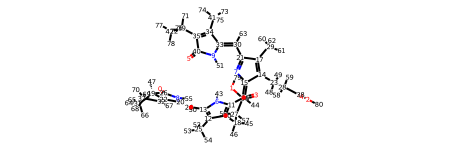

In [8]:
# get index for alignment
lig = 'PCB'
m_mol = lig_mols[lig][1]
for atom in m_mol.GetAtoms():
    atom.SetProp('atomLabel',str(atom.GetIdx()))
m_mol

In [9]:
# select a functional group for alignment
ligands['PCB'][2] = (7,15,14,17,21) #ring 2
#ligands['PCB'][2] = list(range(1, 81))

highlight (7, 15, 14, 17, 21)


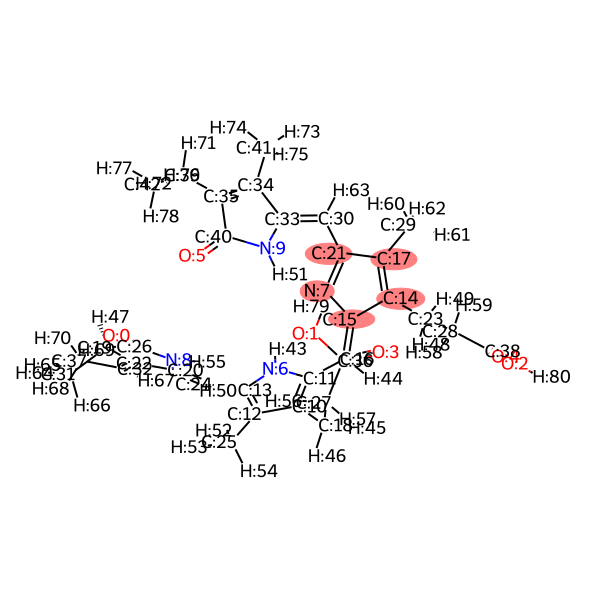

In [10]:
## Check if highlighted correct atoms
## To do: figure out how to display multiple ligands at the same time.
## TODO: how to show in 2D to make ligand ID more visible. Cannot transfer to smile then read, since 
##       molecule order got changed
#**Need user input here**
#atom index 10 to 18 (1-indexing)
#Starting from 1 in mol2 idxing
lig = 'PCB'
atm_idx_to_align = ligands[lig][2] # VIB: range(10,19)
print(f'highlight {atm_idx_to_align}')

#Drawing with atom numbers and assigned atoms highlighted to check the above 
m_id_draw = copy.deepcopy(lig_mols[lig][0])
n_atm = m_id_draw.GetNumAtoms()
for idx in range(n_atm):
    m_id_draw.GetAtomWithIdx(idx).SetProp('molAtomMapNumber',str(m_id_draw.GetAtomWithIdx(idx).GetIdx()))

#Highlight the assigned atoms, these atms are used for alignments
Chem.Draw.MolToImage(m_id_draw,size=(600,600),highlightAtoms=atm_idx_to_align)

In [11]:
# # roll the mouse, molecule may not be in te center of the view, thus not showing up.
# # ? how to center the molecule from start ?
py3d = py3Dmol.view(width=600,height=200)
# py3d.addModel(Chem.MolToMolBlock(lig_mols['FOL'][0]))
# py3d.setStyle({'stick':{}})
# py3d.render()

In [12]:
def conformer_generation(m_mol):
    Chem.SanitizeMol(m_mol) ##Wenhan: assign the correct aromatic bonds
    # Generate conformers
    p = AllChem.ETKDGv2()
    p.verbose = True

    #Check if it's using the torsion angle parameters from the experimental database
    print(f'Use torsion angle parameters: {p.useExpTorsionAnglePrefs}')

    #p is for the generation method (here ETKDGv2 assigned as above)
    #The generation is stochastic
    cids = AllChem.EmbedMultipleConfs(m_mol, N_CONF, p)
    Chem.SanitizeMol(m_mol)

    #double check the num. of conformers
    n_conf = m_mol.GetNumConformers()
    print(f'num of conf: {n_conf}')

    #Optimize and calculate energy using a molecular mechanics force field.
    #Doing a simple calc. here just to pick cluster centers.
    #Note the converged molecules are local minimum, the results are related with start state
    cenergy = []
    
    for conf in cids:
        ITER_NUM = 50
        converged = Chem.AllChem.MMFFOptimizeMolecule(m_mol,confId=conf,maxIters=ITER_NUM)
        while converged != 0:
            ITER_NUM += 50
            converged = Chem.AllChem.MMFFOptimizeMolecule(m_mol,confId=conf,maxIters=ITER_NUM)
        print(f'rotamer{conf} converged after {ITER_NUM} iteration? {converged}')
        mp = Chem.AllChem.MMFFGetMoleculeProperties(m_mol)
        cenergy.append(Chem.AllChem.MMFFGetMoleculeForceField(m_mol,mp,confId=conf).CalcEnergy())

    sorted_cids = sorted(cids,key=lambda cid: cenergy[cid])
    print(len(sorted_cids))
    sns.distplot(cenergy)
    plt.title('conformer MMFF energy distribution')
    print (min(cenergy),max(cenergy))
    plt.show()
    
    return sorted_cids,cenergy

PCB
Use torsion angle parameters: True


[13:13:07] [CX3:1]=[CX3:2]!@;-[CH2:3][C:4]: 17 14 23 28, [(1 0), (1 0), (-1 1.5), (1 0), (1 0), (1 0)] 
[13:13:07] [CX3:1]=[CX3:2]!@;-[CH2:3][C:4]: 34 35 39 42, [(1 0), (1 0), (-1 1.5), (1 0), (1 0), (1 0)] 
[13:13:07] [*^2:1]~[C^2:2]([!H])!@;-[C^2:3]~[*^2:4]: 7 21 30 33, [(1 0), (-1 15), (1 0), (1 0), (1 0), (1 0)] 
[13:13:07] [!#1:1][CX4H2:2]!@;-[CX4H2:3][!#1:4]: 10 18 27 36, [(1 0), (1 0), (1 4), (1 0), (1 0), (1 0)] 
[13:13:07] [!#1:1][CX4H2:2]!@;-[CX4H2:3][!#1:4]: 14 23 28 38, [(1 0), (1 0), (1 4), (1 0), (1 0), (1 0)] 
[13:13:07] [C:1][CX4H2:2]!@;-[CX3:3]=[O:4]: 18 27 36 3, [(1 -1), (1 -0.5), (1 -0.2), (1 -0.3), (1 0), (1 -0.3)] 
[13:13:07] [C:1][CX4H2:2]!@;-[CX3:3]=[O:4]: 23 28 38 4, [(1 -1), (1 -0.5), (1 -0.2), (1 -0.3), (1 0), (1 -0.3)] 
[13:13:07] [cH0:1][c:2]!@;-[CX4H2:3][CX4:4]: 11 10 18 27, [(-1 -1.3), (1 1.6), (-1 -0.6), (-1 0.6), (1 -0.1), (-1 0.3)] 
[13:13:07] [a:1][c:2]!@;-[CX3:3]=[CX3H0:4]: 6 11 16 15, [(1 0), (-1 0.7), (1 0), (1 0.6), (1 0), (1 -0.5)] 
[13:13:07] [a:

num of conf: 2500
rotamer0 converged after 300 iteration? 0
rotamer1 converged after 300 iteration? 0
rotamer2 converged after 250 iteration? 0
rotamer3 converged after 250 iteration? 0
rotamer4 converged after 300 iteration? 0
rotamer5 converged after 300 iteration? 0
rotamer6 converged after 400 iteration? 0
rotamer7 converged after 350 iteration? 0
rotamer8 converged after 350 iteration? 0
rotamer9 converged after 350 iteration? 0
rotamer10 converged after 300 iteration? 0
rotamer11 converged after 300 iteration? 0
rotamer12 converged after 300 iteration? 0
rotamer13 converged after 300 iteration? 0
rotamer14 converged after 300 iteration? 0
rotamer15 converged after 250 iteration? 0
rotamer16 converged after 300 iteration? 0
rotamer17 converged after 300 iteration? 0
rotamer18 converged after 250 iteration? 0
rotamer19 converged after 300 iteration? 0
rotamer20 converged after 250 iteration? 0
rotamer21 converged after 350 iteration? 0
rotamer22 converged after 300 iteration? 0
rot

rotamer189 converged after 350 iteration? 0
rotamer190 converged after 300 iteration? 0
rotamer191 converged after 300 iteration? 0
rotamer192 converged after 300 iteration? 0
rotamer193 converged after 250 iteration? 0
rotamer194 converged after 300 iteration? 0
rotamer195 converged after 300 iteration? 0
rotamer196 converged after 300 iteration? 0
rotamer197 converged after 300 iteration? 0
rotamer198 converged after 250 iteration? 0
rotamer199 converged after 250 iteration? 0
rotamer200 converged after 250 iteration? 0
rotamer201 converged after 300 iteration? 0
rotamer202 converged after 250 iteration? 0
rotamer203 converged after 250 iteration? 0
rotamer204 converged after 300 iteration? 0
rotamer205 converged after 300 iteration? 0
rotamer206 converged after 250 iteration? 0
rotamer207 converged after 300 iteration? 0
rotamer208 converged after 300 iteration? 0
rotamer209 converged after 250 iteration? 0
rotamer210 converged after 300 iteration? 0
rotamer211 converged after 300 i

rotamer376 converged after 300 iteration? 0
rotamer377 converged after 300 iteration? 0
rotamer378 converged after 250 iteration? 0
rotamer379 converged after 300 iteration? 0
rotamer380 converged after 250 iteration? 0
rotamer381 converged after 300 iteration? 0
rotamer382 converged after 250 iteration? 0
rotamer383 converged after 300 iteration? 0
rotamer384 converged after 250 iteration? 0
rotamer385 converged after 300 iteration? 0
rotamer386 converged after 350 iteration? 0
rotamer387 converged after 300 iteration? 0
rotamer388 converged after 300 iteration? 0
rotamer389 converged after 300 iteration? 0
rotamer390 converged after 350 iteration? 0
rotamer391 converged after 300 iteration? 0
rotamer392 converged after 300 iteration? 0
rotamer393 converged after 300 iteration? 0
rotamer394 converged after 250 iteration? 0
rotamer395 converged after 350 iteration? 0
rotamer396 converged after 300 iteration? 0
rotamer397 converged after 300 iteration? 0
rotamer398 converged after 300 i

rotamer563 converged after 300 iteration? 0
rotamer564 converged after 250 iteration? 0
rotamer565 converged after 300 iteration? 0
rotamer566 converged after 250 iteration? 0
rotamer567 converged after 300 iteration? 0
rotamer568 converged after 350 iteration? 0
rotamer569 converged after 300 iteration? 0
rotamer570 converged after 350 iteration? 0
rotamer571 converged after 300 iteration? 0
rotamer572 converged after 300 iteration? 0
rotamer573 converged after 250 iteration? 0
rotamer574 converged after 300 iteration? 0
rotamer575 converged after 300 iteration? 0
rotamer576 converged after 300 iteration? 0
rotamer577 converged after 250 iteration? 0
rotamer578 converged after 300 iteration? 0
rotamer579 converged after 300 iteration? 0
rotamer580 converged after 300 iteration? 0
rotamer581 converged after 300 iteration? 0
rotamer582 converged after 300 iteration? 0
rotamer583 converged after 300 iteration? 0
rotamer584 converged after 300 iteration? 0
rotamer585 converged after 300 i

rotamer750 converged after 250 iteration? 0
rotamer751 converged after 250 iteration? 0
rotamer752 converged after 300 iteration? 0
rotamer753 converged after 300 iteration? 0
rotamer754 converged after 300 iteration? 0
rotamer755 converged after 250 iteration? 0
rotamer756 converged after 300 iteration? 0
rotamer757 converged after 300 iteration? 0
rotamer758 converged after 250 iteration? 0
rotamer759 converged after 300 iteration? 0
rotamer760 converged after 300 iteration? 0
rotamer761 converged after 300 iteration? 0
rotamer762 converged after 300 iteration? 0
rotamer763 converged after 300 iteration? 0
rotamer764 converged after 300 iteration? 0
rotamer765 converged after 300 iteration? 0
rotamer766 converged after 250 iteration? 0
rotamer767 converged after 250 iteration? 0
rotamer768 converged after 250 iteration? 0
rotamer769 converged after 300 iteration? 0
rotamer770 converged after 300 iteration? 0
rotamer771 converged after 300 iteration? 0
rotamer772 converged after 300 i

rotamer938 converged after 300 iteration? 0
rotamer939 converged after 250 iteration? 0
rotamer940 converged after 250 iteration? 0
rotamer941 converged after 300 iteration? 0
rotamer942 converged after 250 iteration? 0
rotamer943 converged after 300 iteration? 0
rotamer944 converged after 300 iteration? 0
rotamer945 converged after 250 iteration? 0
rotamer946 converged after 300 iteration? 0
rotamer947 converged after 300 iteration? 0
rotamer948 converged after 300 iteration? 0
rotamer949 converged after 300 iteration? 0
rotamer950 converged after 300 iteration? 0
rotamer951 converged after 300 iteration? 0
rotamer952 converged after 300 iteration? 0
rotamer953 converged after 300 iteration? 0
rotamer954 converged after 300 iteration? 0
rotamer955 converged after 350 iteration? 0
rotamer956 converged after 300 iteration? 0
rotamer957 converged after 300 iteration? 0
rotamer958 converged after 300 iteration? 0
rotamer959 converged after 350 iteration? 0
rotamer960 converged after 300 i

rotamer1122 converged after 300 iteration? 0
rotamer1123 converged after 300 iteration? 0
rotamer1124 converged after 300 iteration? 0
rotamer1125 converged after 350 iteration? 0
rotamer1126 converged after 300 iteration? 0
rotamer1127 converged after 300 iteration? 0
rotamer1128 converged after 300 iteration? 0
rotamer1129 converged after 250 iteration? 0
rotamer1130 converged after 250 iteration? 0
rotamer1131 converged after 300 iteration? 0
rotamer1132 converged after 250 iteration? 0
rotamer1133 converged after 300 iteration? 0
rotamer1134 converged after 250 iteration? 0
rotamer1135 converged after 300 iteration? 0
rotamer1136 converged after 350 iteration? 0
rotamer1137 converged after 350 iteration? 0
rotamer1138 converged after 300 iteration? 0
rotamer1139 converged after 250 iteration? 0
rotamer1140 converged after 350 iteration? 0
rotamer1141 converged after 300 iteration? 0
rotamer1142 converged after 300 iteration? 0
rotamer1143 converged after 300 iteration? 0
rotamer114

rotamer1306 converged after 300 iteration? 0
rotamer1307 converged after 300 iteration? 0
rotamer1308 converged after 350 iteration? 0
rotamer1309 converged after 350 iteration? 0
rotamer1310 converged after 250 iteration? 0
rotamer1311 converged after 300 iteration? 0
rotamer1312 converged after 300 iteration? 0
rotamer1313 converged after 250 iteration? 0
rotamer1314 converged after 300 iteration? 0
rotamer1315 converged after 250 iteration? 0
rotamer1316 converged after 350 iteration? 0
rotamer1317 converged after 300 iteration? 0
rotamer1318 converged after 300 iteration? 0
rotamer1319 converged after 300 iteration? 0
rotamer1320 converged after 300 iteration? 0
rotamer1321 converged after 300 iteration? 0
rotamer1322 converged after 300 iteration? 0
rotamer1323 converged after 250 iteration? 0
rotamer1324 converged after 300 iteration? 0
rotamer1325 converged after 300 iteration? 0
rotamer1326 converged after 250 iteration? 0
rotamer1327 converged after 300 iteration? 0
rotamer132

rotamer1489 converged after 300 iteration? 0
rotamer1490 converged after 300 iteration? 0
rotamer1491 converged after 250 iteration? 0
rotamer1492 converged after 250 iteration? 0
rotamer1493 converged after 350 iteration? 0
rotamer1494 converged after 300 iteration? 0
rotamer1495 converged after 250 iteration? 0
rotamer1496 converged after 300 iteration? 0
rotamer1497 converged after 350 iteration? 0
rotamer1498 converged after 300 iteration? 0
rotamer1499 converged after 300 iteration? 0
rotamer1500 converged after 250 iteration? 0
rotamer1501 converged after 300 iteration? 0
rotamer1502 converged after 250 iteration? 0
rotamer1503 converged after 300 iteration? 0
rotamer1504 converged after 300 iteration? 0
rotamer1505 converged after 300 iteration? 0
rotamer1506 converged after 300 iteration? 0
rotamer1507 converged after 300 iteration? 0
rotamer1508 converged after 300 iteration? 0
rotamer1509 converged after 300 iteration? 0
rotamer1510 converged after 300 iteration? 0
rotamer151

rotamer1672 converged after 400 iteration? 0
rotamer1673 converged after 300 iteration? 0
rotamer1674 converged after 250 iteration? 0
rotamer1675 converged after 300 iteration? 0
rotamer1676 converged after 300 iteration? 0
rotamer1677 converged after 300 iteration? 0
rotamer1678 converged after 300 iteration? 0
rotamer1679 converged after 300 iteration? 0
rotamer1680 converged after 300 iteration? 0
rotamer1681 converged after 300 iteration? 0
rotamer1682 converged after 300 iteration? 0
rotamer1683 converged after 300 iteration? 0
rotamer1684 converged after 300 iteration? 0
rotamer1685 converged after 250 iteration? 0
rotamer1686 converged after 300 iteration? 0
rotamer1687 converged after 350 iteration? 0
rotamer1688 converged after 300 iteration? 0
rotamer1689 converged after 250 iteration? 0
rotamer1690 converged after 300 iteration? 0
rotamer1691 converged after 300 iteration? 0
rotamer1692 converged after 300 iteration? 0
rotamer1693 converged after 250 iteration? 0
rotamer169

rotamer1856 converged after 300 iteration? 0
rotamer1857 converged after 300 iteration? 0
rotamer1858 converged after 300 iteration? 0
rotamer1859 converged after 300 iteration? 0
rotamer1860 converged after 300 iteration? 0
rotamer1861 converged after 250 iteration? 0
rotamer1862 converged after 250 iteration? 0
rotamer1863 converged after 300 iteration? 0
rotamer1864 converged after 300 iteration? 0
rotamer1865 converged after 350 iteration? 0
rotamer1866 converged after 250 iteration? 0
rotamer1867 converged after 300 iteration? 0
rotamer1868 converged after 300 iteration? 0
rotamer1869 converged after 300 iteration? 0
rotamer1870 converged after 250 iteration? 0
rotamer1871 converged after 300 iteration? 0
rotamer1872 converged after 250 iteration? 0
rotamer1873 converged after 250 iteration? 0
rotamer1874 converged after 300 iteration? 0
rotamer1875 converged after 250 iteration? 0
rotamer1876 converged after 250 iteration? 0
rotamer1877 converged after 300 iteration? 0
rotamer187

rotamer2039 converged after 300 iteration? 0
rotamer2040 converged after 300 iteration? 0
rotamer2041 converged after 250 iteration? 0
rotamer2042 converged after 300 iteration? 0
rotamer2043 converged after 250 iteration? 0
rotamer2044 converged after 300 iteration? 0
rotamer2045 converged after 300 iteration? 0
rotamer2046 converged after 300 iteration? 0
rotamer2047 converged after 300 iteration? 0
rotamer2048 converged after 300 iteration? 0
rotamer2049 converged after 300 iteration? 0
rotamer2050 converged after 250 iteration? 0
rotamer2051 converged after 250 iteration? 0
rotamer2052 converged after 300 iteration? 0
rotamer2053 converged after 300 iteration? 0
rotamer2054 converged after 250 iteration? 0
rotamer2055 converged after 300 iteration? 0
rotamer2056 converged after 300 iteration? 0
rotamer2057 converged after 300 iteration? 0
rotamer2058 converged after 300 iteration? 0
rotamer2059 converged after 300 iteration? 0
rotamer2060 converged after 250 iteration? 0
rotamer206

rotamer2223 converged after 300 iteration? 0
rotamer2224 converged after 300 iteration? 0
rotamer2225 converged after 300 iteration? 0
rotamer2226 converged after 350 iteration? 0
rotamer2227 converged after 300 iteration? 0
rotamer2228 converged after 300 iteration? 0
rotamer2229 converged after 300 iteration? 0
rotamer2230 converged after 300 iteration? 0
rotamer2231 converged after 250 iteration? 0
rotamer2232 converged after 250 iteration? 0
rotamer2233 converged after 250 iteration? 0
rotamer2234 converged after 300 iteration? 0
rotamer2235 converged after 300 iteration? 0
rotamer2236 converged after 300 iteration? 0
rotamer2237 converged after 250 iteration? 0
rotamer2238 converged after 300 iteration? 0
rotamer2239 converged after 250 iteration? 0
rotamer2240 converged after 300 iteration? 0
rotamer2241 converged after 250 iteration? 0
rotamer2242 converged after 300 iteration? 0
rotamer2243 converged after 300 iteration? 0
rotamer2244 converged after 300 iteration? 0
rotamer224

rotamer2406 converged after 300 iteration? 0
rotamer2407 converged after 300 iteration? 0
rotamer2408 converged after 350 iteration? 0
rotamer2409 converged after 300 iteration? 0
rotamer2410 converged after 300 iteration? 0
rotamer2411 converged after 300 iteration? 0
rotamer2412 converged after 250 iteration? 0
rotamer2413 converged after 300 iteration? 0
rotamer2414 converged after 300 iteration? 0
rotamer2415 converged after 300 iteration? 0
rotamer2416 converged after 300 iteration? 0
rotamer2417 converged after 300 iteration? 0
rotamer2418 converged after 300 iteration? 0
rotamer2419 converged after 300 iteration? 0
rotamer2420 converged after 300 iteration? 0
rotamer2421 converged after 350 iteration? 0
rotamer2422 converged after 300 iteration? 0
rotamer2423 converged after 300 iteration? 0
rotamer2424 converged after 300 iteration? 0
rotamer2425 converged after 300 iteration? 0
rotamer2426 converged after 300 iteration? 0
rotamer2427 converged after 300 iteration? 0
rotamer242

/tmp/ipykernel_13310/2733140022.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cenergy)


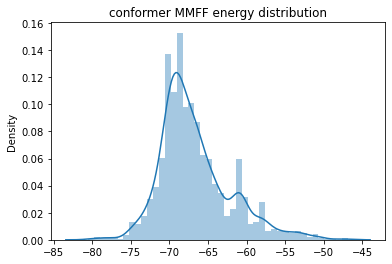

In [13]:
lig_rotamers = {}
for lig in ligands:
    print(lig)
    lig_rotamers[lig] = conformer_generation(lig_mols[lig][1])

# Conformer alignment and clustering

- Currently it aligns the conformers using specific atoms that are pre-assigned and you need to know the indices of the atoms beforehand.
- Here it is good to selected one functional group to do the alignment and calculated RMSD (without new all-atom alignment) to do clustering. This was done to give more weights on atoms that are rotating when one functional group is set as a reference. GRL thinks the minimzed RMSD that we get as a result of doing all-atom alignment can be misleading when we want to focus on torsion angle differences. But I haven't done any benchmark and the approach can change depending on what you need.
- Alternatively, you could try using the Torsion Fingerprints as a distance metric. See code below for
`if CL_MODE == 'TFD':`
    `Clustering using torsion fingerprints`
    `dmat = TorsionFingerprints.GetTFDMatrix(m_mol)`

## ***ASSIGN ATOM INDICES FOR ALIGNMENT HERE***

In [14]:
lig = 'PCB'
ref_mol = lig_mols[lig][0]
m_mol = lig_mols[lig][1]
atm_ids = ligands[lig][2]
# for n,conf in enumerate(lig_rotamers[lig][0]): # cids:
#     if n < 2:
#     #This returns the rms of thelig_rotamers[lig][0] atoms in atm_ids only, and we will not use that
# #     tmp_rms = rdMolAlign.AlignMol(m_mol,ref_mol,conf,-1,atm_ids)
# #     symm_best_rmslist.append(rdMolAlign.GetBestRMS(m_mol,ref_mol,conf))
#     #
#         py3d.addModel(Chem.MolToMolBlock(m_mol,confId=conf))
py3d.addModel(Chem.MolToMolBlock(m_mol,confId=1))
py3d.setStyle({'stick':{}})
py3d.render()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [15]:
def align_and_get_rmsd(ref_mol,m_mol,atm_idx_to_align,sorted_cids):
    #Get a paired list of atom indices that you want to use for alignment
    i_atm = 0
    atm_ids = []
    for atom in ref_mol.GetAtoms():
        i_atm += 1
        a_idx = atom.GetIdx() #index
        if i_atm in atm_idx_to_align:
            atm_ids.append((a_idx,a_idx))
    ##Other info you can get
    #    print (atom.GetHybridization())
    #    print (atom.GetFormalCharge()) #not in sdf format ? how to load from input mol2 ?
    #    print (atom.GetDegree()) #number of bonded neighbors
    #    print (atom.GetChiralTag())
    #    atom.GetAtomicNum() #periodic number
    #    print (a_idx, atom.GetAtomicNum())

    #align to reference mol (input) using the assigned atoms
    symm_best_rmslist = []
    for conf in sorted_cids: # cids:
        #This returns the rms of the atoms in atm_ids only, and we will not use that
        tmp_rms = rdMolAlign.AlignMol(m_mol,ref_mol,conf,-1,atm_ids)
        print(tmp_rms)
        #
        #Calculating this just in case. Not used now.
        #This will calculate RMSD considering the symmetry
    #     symm_best_rmslist.append(rdMolAlign.CalcRMS(m_mol,ref_mol,conf)) #ERROR: cannot use CalcRMS
    #     symm_best_rmslist.append(rdMolAlign.GetAlignmentTransform(m_mol,ref_mol,conf)[0]) # this methods may align molecules by sliding them
        symm_best_rmslist.append(rdMolAlign.GetBestRMS(m_mol,ref_mol,conf))
        #
        py3d.addModel(Chem.MolToMolBlock(m_mol,confId=conf))
    #some useful things related to RMSD
    #Calcuate rmsd as prealigned using the assigned atoms
    #This would give emphasis to the rotating group (higher rmsd than below)
    #rmsd_mat = AllChem.GetConformerRMSMatrix(m_mol,prealigned=True)
    #calculate rmsd with alignment to the first conformer (this would use all atom)
    #all_atm_rmsd_mat = AllChem.GetConformerRMSMatrix(m_mol,prealigned=False)
    #
    #Note that the returned RMS matrix is symmetrical, i.e. it is the lower half of the matrix, e.g. for 5 conformers:
    #
    #rmsmatrix = [ a,
    #              b, c,
    #              d, e, f,
    #              g, h, i, j]
    #
    #for specific pair
    #AllChem.GetConformerRMS(m_mol,0,49,prealigned=True)
    #
    #https://rdkit.readthedocs.io/en/latest/Cookbook.html
    # unlike AlignMol this takes care of symmetry
    #          spread_values.append(str(AllChem.GetBestRMS(mols[i], mols[j])))

    #show all N_CONF. Check if they have been aligned with the atoms of interest
    py3d.setStyle({'stick':{}})
    py3d.render()
    
    return symm_best_rmslist

In [16]:
print(f"Reference molecule atom count: {ref_mol.GetNumAtoms()}")
print(f"Probe molecule atom count: {m_mol.GetNumAtoms()}")
print(f"Alignment atom indices: {atm_idx_to_align}")
print(f"Atom indices for alignment: {ligands[lig][1]}, Type: {type(ligands[lig][1])}")

Reference molecule atom count: 81
Probe molecule atom count: 81
Alignment atom indices: (7, 15, 14, 17, 21)
Atom indices for alignment: new_pcb.mol2, Type: <class 'str'>


In [17]:
print(ref_mol.GetSubstructMatch(m_mol))

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80)


In [18]:
Chem.SanitizeMol(ref_mol)
Chem.SanitizeMol(m_mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

In [20]:
print(ref_mol.GetSubstructMatch(m_mol))

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80)


In [21]:
for lig in ligands:
    m_mol = lig_mols[lig][1]  # Molecule with conformers
    ref_mol = lig_mols[lig][0]  # Reference molecule
    num_confs = m_mol.GetNumConformers()  # Total conformers

    # Set custom save path
    save_path = "/home/wh621/Desktop/output_RDKit2500/"

    # Ensure the output directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save each conformer separately
    print(f'Saving each conformer to separate PDB files in {save_path}')
    
    for conf_id in range(num_confs):
        pdb_file = f'{save_path}/{lig}_conf_{conf_id+1}.pdb'
        with Chem.PDBWriter(pdb_file) as pdb_writer:
            print(f'Writing conformer {conf_id} to {pdb_file}')
            pdb_writer.write(m_mol, confId=conf_id)

Saving each conformer to separate PDB files in /home/wh621/Desktop/output_RDKit2500/
Writing conformer 0 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1.pdb
Writing conformer 1 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2.pdb
Writing conformer 2 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_3.pdb
Writing conformer 3 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_4.pdb
Writing conformer 4 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_5.pdb
Writing conformer 5 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_6.pdb
Writing conformer 6 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_7.pdb
Writing conformer 7 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_8.pdb
Writing conformer 8 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_9.pdb
Writing conformer 9 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_10.pdb
Writing conformer 10 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_11.pdb
Writing conformer 11 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_12.pd

Writing conformer 178 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_179.pdb
Writing conformer 179 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_180.pdb
Writing conformer 180 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_181.pdb
Writing conformer 181 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_182.pdb
Writing conformer 182 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_183.pdb
Writing conformer 183 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_184.pdb
Writing conformer 184 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_185.pdb
Writing conformer 185 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_186.pdb
Writing conformer 186 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_187.pdb
Writing conformer 187 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_188.pdb
Writing conformer 188 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_189.pdb
Writing conformer 189 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_190.pdb
Writing conformer 190 to /home/wh621/Des

Writing conformer 380 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_381.pdb
Writing conformer 381 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_382.pdb
Writing conformer 382 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_383.pdb
Writing conformer 383 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_384.pdb
Writing conformer 384 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_385.pdb
Writing conformer 385 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_386.pdb
Writing conformer 386 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_387.pdb
Writing conformer 387 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_388.pdb
Writing conformer 388 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_389.pdb
Writing conformer 389 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_390.pdb
Writing conformer 390 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_391.pdb
Writing conformer 391 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_392.pdb
Writing conformer 392 to /home/wh621/Des

Writing conformer 649 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_650.pdb
Writing conformer 650 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_651.pdb
Writing conformer 651 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_652.pdb
Writing conformer 652 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_653.pdb
Writing conformer 653 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_654.pdb
Writing conformer 654 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_655.pdb
Writing conformer 655 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_656.pdb
Writing conformer 656 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_657.pdb
Writing conformer 657 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_658.pdb
Writing conformer 658 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_659.pdb
Writing conformer 659 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_660.pdb
Writing conformer 660 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_661.pdb
Writing conformer 661 to /home/wh621/Des

Writing conformer 861 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_862.pdb
Writing conformer 862 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_863.pdb
Writing conformer 863 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_864.pdb
Writing conformer 864 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_865.pdb
Writing conformer 865 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_866.pdb
Writing conformer 866 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_867.pdb
Writing conformer 867 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_868.pdb
Writing conformer 868 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_869.pdb
Writing conformer 869 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_870.pdb
Writing conformer 870 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_871.pdb
Writing conformer 871 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_872.pdb
Writing conformer 872 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_873.pdb
Writing conformer 873 to /home/wh621/Des

Writing conformer 1068 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1069.pdb
Writing conformer 1069 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1070.pdb
Writing conformer 1070 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1071.pdb
Writing conformer 1071 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1072.pdb
Writing conformer 1072 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1073.pdb
Writing conformer 1073 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1074.pdb
Writing conformer 1074 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1075.pdb
Writing conformer 1075 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1076.pdb
Writing conformer 1076 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1077.pdb
Writing conformer 1077 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1078.pdb
Writing conformer 1078 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1079.pdb
Writing conformer 1079 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1080.pdb
Writing conforme

Writing conformer 1254 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1255.pdb
Writing conformer 1255 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1256.pdb
Writing conformer 1256 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1257.pdb
Writing conformer 1257 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1258.pdb
Writing conformer 1258 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1259.pdb
Writing conformer 1259 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1260.pdb
Writing conformer 1260 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1261.pdb
Writing conformer 1261 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1262.pdb
Writing conformer 1262 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1263.pdb
Writing conformer 1263 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1264.pdb
Writing conformer 1264 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1265.pdb
Writing conformer 1265 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1266.pdb
Writing conforme

Writing conformer 1433 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1434.pdb
Writing conformer 1434 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1435.pdb
Writing conformer 1435 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1436.pdb
Writing conformer 1436 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1437.pdb
Writing conformer 1437 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1438.pdb
Writing conformer 1438 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1439.pdb
Writing conformer 1439 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1440.pdb
Writing conformer 1440 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1441.pdb
Writing conformer 1441 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1442.pdb
Writing conformer 1442 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1443.pdb
Writing conformer 1443 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1444.pdb
Writing conformer 1444 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1445.pdb
Writing conforme

Writing conformer 1636 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1637.pdb
Writing conformer 1637 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1638.pdb
Writing conformer 1638 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1639.pdb
Writing conformer 1639 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1640.pdb
Writing conformer 1640 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1641.pdb
Writing conformer 1641 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1642.pdb
Writing conformer 1642 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1643.pdb
Writing conformer 1643 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1644.pdb
Writing conformer 1644 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1645.pdb
Writing conformer 1645 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1646.pdb
Writing conformer 1646 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1647.pdb
Writing conformer 1647 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1648.pdb
Writing conforme

Writing conformer 1833 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1834.pdb
Writing conformer 1834 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1835.pdb
Writing conformer 1835 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1836.pdb
Writing conformer 1836 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1837.pdb
Writing conformer 1837 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1838.pdb
Writing conformer 1838 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1839.pdb
Writing conformer 1839 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1840.pdb
Writing conformer 1840 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1841.pdb
Writing conformer 1841 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1842.pdb
Writing conformer 1842 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1843.pdb
Writing conformer 1843 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1844.pdb
Writing conformer 1844 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_1845.pdb
Writing conforme

Writing conformer 2012 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2013.pdb
Writing conformer 2013 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2014.pdb
Writing conformer 2014 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2015.pdb
Writing conformer 2015 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2016.pdb
Writing conformer 2016 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2017.pdb
Writing conformer 2017 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2018.pdb
Writing conformer 2018 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2019.pdb
Writing conformer 2019 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2020.pdb
Writing conformer 2020 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2021.pdb
Writing conformer 2021 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2022.pdb
Writing conformer 2022 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2023.pdb
Writing conformer 2023 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2024.pdb
Writing conforme

Writing conformer 2263 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2264.pdb
Writing conformer 2264 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2265.pdb
Writing conformer 2265 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2266.pdb
Writing conformer 2266 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2267.pdb
Writing conformer 2267 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2268.pdb
Writing conformer 2268 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2269.pdb
Writing conformer 2269 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2270.pdb
Writing conformer 2270 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2271.pdb
Writing conformer 2271 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2272.pdb
Writing conformer 2272 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2273.pdb
Writing conformer 2273 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2274.pdb
Writing conformer 2274 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2275.pdb
Writing conforme

Writing conformer 2432 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2433.pdb
Writing conformer 2433 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2434.pdb
Writing conformer 2434 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2435.pdb
Writing conformer 2435 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2436.pdb
Writing conformer 2436 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2437.pdb
Writing conformer 2437 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2438.pdb
Writing conformer 2438 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2439.pdb
Writing conformer 2439 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2440.pdb
Writing conformer 2440 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2441.pdb
Writing conformer 2441 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2442.pdb
Writing conformer 2442 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2443.pdb
Writing conformer 2443 to /home/wh621/Desktop/output_RDKit2500//PCB_conf_2444.pdb
Writing conforme

In [ ]:
lig_rmsd = {}
# def align_and_get_rmsd(ref_mol,m_mol,atm_idx_to_align,sorted_cids):
for lig in ligands:
    print(f'{lig} align on {ligands[lig][2]}')
    lig_rmsd[lig] = align_and_get_rmsd(lig_mols[lig][0],lig_mols[lig][1],ligands[lig][2],lig_rotamers[lig][0])

PCB align on (7, 15, 14, 17, 21)
0.31990032987945305
0.20052470998409025
0.2435620993319022
0.2435596786809052
0.35841600393516043
0.48052084139514384
0.5682204331968346
0.5682015918739467
0.5351194721516891
0.4537615279795349
0.31452982061021195
0.17379893848500086
0.17380134395713037
0.24975544366532357
0.42051240713103694
0.5191936912654334
0.44976556063862333
0.45822575309810415
0.4187695595188991
0.43035131360964185
0.4470098242447903
0.42479868043284424
0.434573956236039
0.40562704743554595
0.4704858359032492
0.15936948115387028
0.24034955980642705
0.20770582048421718
0.20771157619041114
0.26462154348901684
0.26461960223754644
0.26461551625187096
0.2646179114347267
0.41954271646327135
0.3365517486569129
0.49794125668789857
0.34023914446040127
0.3402384653659976
0.32665219804120643
0.17234593451356736
0.17234760757372383
0.17234547019756455
0.1723459088042448
0.20932667731544224
0.2093253199320091
0.33032782995381155
0.4261816439281771
0.17452024591092088
0.1745275988516626
0.5329

0.3150733799509489
0.3245423015229305
0.3245310338106576
0.3164607813134597
0.360493240328449
0.5228222426456156
0.35877350695837806
0.35875756695016753
0.5835893616455614
0.5835857926932283
0.31876537003641
0.403329618128169
0.40333700454361465
0.20027953659197067
0.20027672778859937
0.20028056735970193
0.20028439755243913
0.20027293693474124
0.20027647580355445
0.20026874852428295
0.20028436255606205
0.20026664052743937
0.2002753523566076
0.32062323112074653
0.32044098663993026
0.36250802089617296
0.3625058147001286
0.44503358603654697
0.34999790264142544
0.20655351887739765
0.20655769031072263
0.20655908556996266
0.2065460458973712
0.20653537611862854
0.2065610949373516
0.4520410412669487
0.452041395408243
0.4520237419576458
0.45353127155350204
0.4535257949540825
0.45356591235205923
0.36402254363424236
0.1990005843370848
0.19899620260443512
0.1989999830145226
0.19899213963143197
0.36015763548156454
0.36015405245087717
0.31801406219941736
0.4509705044791855
0.3401020544209139
0.35180

In [ ]:
for lig in ligands:
    plt.hist(lig_rmsd[lig],bins = 50,label=lig)
plt.legend()
plt.show()

In [ ]:
lig_cluster = {}
for lig in ligands:
    #CL_MODE = 'TFD'
    CL_MODE = 'RMSD'
    m_mol = lig_mols[lig][1]
    ref_mol = lig_mols[lig][0]
    #
    if CL_MODE == 'TFD':
        #Clustering using torsion fingerprints
        #Not used at the moment.
        dmat = TorsionFingerprints.GetTFDMatrix(m_mol)
        THRESHOLD = 0.2
    elif CL_MODE == 'RMSD':
        #Clustering using rmsd
        dmat = AllChem.GetConformerRMSMatrix(m_mol, prealigned=True)
        #Can change the threshold
        THRESHOLD = 1.5
    #
    cluster_groups = Butina.ClusterData(dmat, m_mol.GetNumConformers(), THRESHOLD, isDistData=True, reordering=False)
    lig_cluster[lig] = cluster_groups
    # plot cluster distribution
    sns.distplot(dmat)
    plt.title('conformer pairwise rmsd distribution')
    plt.figure()

    print(f'{lig} clustered to {len(cluster_groups)} groups: {cluster_groups}')

    #new 3d window to show the reference and the cluster centers
    py3d_cl_center = py3Dmol.view(width=600,height=200)
    py3d_cl_center.addModel(Chem.MolToMolBlock(ref_mol))
    py3d_cl_center.setStyle({'stick':{}})
    #py3d.render()

## Conformer alignment to the input molecule using the assigned atoms

## Clustering and centroid selection

In [ ]:
#TODO: Can I write a mol2 file with rdkit ??
def write_conformers_to_sdf(mol_in,fname,cluster):
    w = Chem.SDWriter(fname)
#    for cluster in rms_clusters:
    for loc_c_id in cluster:
        w.write(mol_in,confId=loc_c_id)
    w.flush()
    w.close()
    return

In [ ]:
## Remove ligands which are are too low in rmsd within each cluster.

In [ ]:
## Wenhan: PDB files output creation.
## Wenhan: ignore all clusters and separate centroids in each file to be use as input for RFDiffusionAA 
for lig in ligands:
    clNo = 0
    emin_cl_center_ids = []
    cluster_group = lig_cluster[lig]
    m_mol = lig_mols[lig][1]  # Molecule with conformers
    ref_mol = lig_mols[lig][0]  # Reference molecule
    cenergy = lig_rotamers[lig][1]

    # Set custom save path
    save_path = "/home/wh621/Desktop/Output_C/"

    # Ensure the output directory exists
    os.makedirs(save_path, exist_ok=True)

    # Process each cluster
    for cluster in cluster_groups:
        clNo += 1
        print(f'###ClNo: {clNo}', 'Member ids:', cluster)

        # Find the lowest-energy conformer in the cluster
        cl_en = {loc_cid: cenergy[loc_cid] for loc_cid in cluster}
        cl_en_sorted = sorted(cl_en.items(), key=lambda item: item[1])
        print(f'Lowest-energy conformer: {cl_en_sorted[0]}')

        # Get the conformer ID with the lowest energy
        cl_cen_loc_id = cl_en_sorted[0][0]
        emin_cl_center_ids.append(cl_cen_loc_id)

    # Save each centroid conformer separately
    print(f'Saving cluster centroids to separate PDB files in {save_path}')
    
    for idx, cid in enumerate(emin_cl_center_ids, start=1):
        centroid_pdb_file = f'{save_path}/{lig}_centroid_{idx}.pdb'
        with Chem.PDBWriter(centroid_pdb_file) as pdb_writer:
            print(f'Writing centroid conformer {cid} to {centroid_pdb_file}')
            pdb_writer.write(m_mol, confId=cid)

    # Save all cluster centers in one file
    print(f'Saving all cluster centers to {save_path}')
    with Chem.PDBWriter(f'{save_path}/{lig}_cl_centers.pdb') as pdb_writer:
        pdb_writer.write(ref_mol)
        for cid in emin_cl_center_ids:
            print(f'Writing center conformer: {cid}')
            pdb_writer.write(m_mol, confId=cid)

In [ ]:
## Wenhan: PDB files output creation.

for lig in ligands:
    clNo = 0
    emin_cl_center_ids = []
    cluster_group = lig_cluster[lig]
    m_mol = lig_mols[lig][1]  # Molecule with conformers
    ref_mol = lig_mols[lig][0]  # Reference molecule
    cenergy = lig_rotamers[lig][1]

    # Set custom save path
    save_path = "/home/wh621/Desktop/Output_PDB/"

    # Ensure the output directory exists
    os.makedirs(save_path, exist_ok=True)

    # Process each cluster
    for cluster in cluster_groups:
        clNo += 1
        print(f'###ClNo: {clNo}', 'Member ids:', cluster)

        # Find the lowest-energy conformer in the cluster
        cl_en = {loc_cid: cenergy[loc_cid] for loc_cid in cluster}
        cl_en_sorted = sorted(cl_en.items(), key=lambda item: item[1])
        print(f'Lowest-energy conformer: {cl_en_sorted[0]}')

        # Get the conformer ID with the lowest energy
        cl_cen_loc_id = cl_en_sorted[0][0]
        emin_cl_center_ids.append(cl_cen_loc_id)

        # Save all cluster members to a PDB file
        with Chem.PDBWriter(f'{save_path}/{lig}_cl{clNo}_members.pdb') as pdb_writer:
            for loc_cid in cluster:
                pdb_writer.write(m_mol, confId=loc_cid)

        py3d_cl_center.addModel(Chem.MolToMolBlock(m_mol, confId=cl_cen_loc_id))

    # Save only the lowest-energy conformer from each cluster
    print(f'Saving all cluster centers to {save_path}')
    with Chem.PDBWriter(f'{save_path}/{lig}_cl_centers.pdb') as pdb_writer:
        pdb_writer.write(ref_mol)
        for cid in emin_cl_center_ids:
            print(f'Writing center conformer: {cid}')
            pdb_writer.write(m_mol, confId=cid)

        cl_fout.write(m_mol, confId=cid)

In [ ]:
#For each cluster pick the energy minimum (MMFF-based) as the center and save id
#Will write the members in each cluster in sdf files 
for lig in ligands:
    clNo = 0
    emin_cl_center_ids = []
    cluster_group = lig_cluster[lig]
    m_mol= lig_mols[lig][1]
    ref_mol = lig_mols[lig][0]
    cenergy = lig_rotamers[lig][1]
    #save each cluster
    for cluster in cluster_groups:
        clNo += 1
        print ('###ClNo: %d'%clNo, 'Member ids :',cluster)
        cl_en = {}
        for loc_cid in cluster:
            c_en = cenergy[loc_cid]
            cl_en[loc_cid] = c_en
        #
        cl_en_sorted = sorted(cl_en.items(),key=lambda item:item[1])
        print (cl_en_sorted[0])
        #id of the emin cluster center
        cl_cen_loc_id = cl_en_sorted[0][0]
        emin_cl_center_ids.append(cl_cen_loc_id)
        #
        #save_path = os.path.dirname(ligands[lig][1])
        save_path = "/home/wh621/Desktop/Output_1000_Ring2/"
        print(f'save cluster{clNo} to {save_path}')
        write_conformers_to_sdf(m_mol,f'{save_path}/{lig}_cl{clNo}_members.sdf',cluster)

        py3d_cl_center.addModel(Chem.MolToMolBlock(m_mol,confId=cl_cen_loc_id))
    
    # save only center rotamer for each cluster
    #Write the reference (input) conformer and the following cluster centers in one sdf file
    print(f'save all to {save_path}')
    # cl_fout = open(f'{save_path}/{lig}_cl_centers.pdb','w')
    cl_fout = Chem.SDWriter(f'{save_path}/{lig}_cl_centers.sdf')
    
    cl_fout.write(ref_mol)
    #
    # cont = []
    # cont.append(Chem.rdmolfiles.MolToPDBBlock(ref_mol,flavor=1))
    #
    for cid in emin_cl_center_ids:
        print(cid)
        cl_fout.write(m_mol,confId=cid)
    #     cont.append(Chem.rdmolfiles.MolToPDBBlock(m_mol,confId=cid,flavor=1))
    #
    # cl_fout.write(''.join(cont))
    # cl_fout.close()

In [ ]:
## Another way: use ANI-Net to rank different conformers

## Generate params file from clustered pdb
- [params file generation protocol](https://new.rosettacommons.org/docs/latest/rosetta_basics/file_types/Residue-Params-file)

In [ ]:
## first check the pdb in pymol to make sure all details look good. No chemical error.
os.chdir(save_path)
!ls

In [ ]:
## Manually check newly generated molecule pdbs, check atom names, chemistry. 
## Check if params file have reseanable rotatable bond defination.
## if yes, congratulations, you're ready to design them.